In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Dataset
import os
import pickle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [38]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=False):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Skip connection with 1x1 convolution when downsampling
        self.downsample = downsample
        if downsample:
            self.skip_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
            self.skip_bn = nn.BatchNorm2d(out_channels)
        else:
            self.skip_conv = None

    def forward(self, x):
        identity = x
        if self.downsample:
            identity = self.skip_bn(self.skip_conv(x))

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity  
        return F.relu(out)

In [39]:
class CustomResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomResNet, self).__init__()

        # Initial Convolution (C1 = 32 channels)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)

        # Residual layers with Max Pooling after each layer
        self.layer1 = self._make_layer(32, 32, num_blocks=2, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1)  # Max pooling after layer1

        self.layer2 = self._make_layer(32, 64, num_blocks=2, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=1)  # Max pooling after layer2

        self.layer3 = self._make_layer(64, 128, num_blocks=2, stride=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=1)  # Max pooling after layer3

        self.layer4 = self._make_layer(128, 256, num_blocks=2, stride=2)

        # Average Pooling (Final layer)
        self.avgpool = nn.AvgPool2d(kernel_size=2, stride=2)

        # Fully Connected Layers
        self.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(1024, 800),  # First FC layer
            nn.ReLU(),
            nn.Linear(800, num_classes)  # Output layer
        )

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride=stride, downsample=True))
        layers.append(ResidualBlock(out_channels, out_channels, stride=1, downsample=False))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))

        x = self.layer1(x)
        x = self.pool1(x)  # Apply max pooling after layer1

        x = self.layer2(x)
        x = self.pool2(x)  # Apply max pooling after layer2

        x = self.layer3(x)
        x = self.pool3(x)  # Apply max pooling after layer3

        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [41]:
model = CustomResNet().to(device)

In [42]:
from torchsummary import summary

# Move model to the correct device (CPU or GPU)
model.to(device)

# Print model summary (assuming input image size is 3×32×32 for CIFAR-10)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           1,024
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
            Conv2d-7           [-1, 32, 32, 32]           9,216
       BatchNorm2d-8           [-1, 32, 32, 32]              64
     ResidualBlock-9           [-1, 32, 32, 32]               0
           Conv2d-10           [-1, 32, 32, 32]           9,216
      BatchNorm2d-11           [-1, 32, 32, 32]              64
           Conv2d-12           [-1, 32, 32, 32]           9,216
      BatchNorm2d-13           [-1, 32, 32, 32]              64
    ResidualBlock-14           [-1, 32,

In [43]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [44]:
def load_cifar10_batches():
    train_data = []
    train_labels = []
    
    for i in range(1, 6):  # data_batch_1 to data_batch_5
        batch_file = os.path.join(data_dir, f"data_batch_{i}")
        batch_dict = unpickle(batch_file)
        
        batch_data = batch_dict[b'data']  # Image data (10000, 3072)
        batch_labels = batch_dict[b'labels']  # Labels (10000,)
        
        train_data.append(batch_data)
        train_labels.extend(batch_labels)
    
    train_data = np.vstack(train_data).reshape(-1, 3, 32, 32).astype(np.float32) / 255.0  # Normalize
    train_labels = np.array(train_labels)
    
    return train_data, train_labels

In [27]:
def load_cifar10_test():
    test_file = os.path.join(data_dir, "test_batch")
    test_dict = unpickle(test_file)
    
    test_data = test_dict[b'data'].reshape(-1, 3, 32, 32).astype(np.float32) / 255.0
    test_labels = np.array(test_dict[b'labels'])
    
    return test_data, test_labels

In [28]:
class CIFAR10Dataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data # (N, 3, 32, 32)
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = np.transpose(self.data[idx], (1, 2, 0))  # (3, 32, 32) -> (32, 32, 3)

        # to PIL
        img = Image.fromarray((img * 255).astype(np.uint8))

        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

In [29]:
def test(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    correct, total = 0, 0
    
    with torch.no_grad():  # Disable gradient computation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)  # Get predicted class
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_acc = 100 * correct / total
    print(f"Test Accuracy: {test_acc:.2f}%")
    return test_acc

In [30]:
data_dir = "./data/cifar-10-batches-py"

In [31]:
# Load Data
train_data, train_labels = load_cifar10_batches()
test_data, test_labels = load_cifar10_test()

# Split Training Set into Training & Validation (80% Train, 20% Validation)
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_data, val_data = train_data[:train_size], train_data[train_size:]
train_labels, val_labels = train_labels[:train_size], train_labels[train_size:]

transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Create Dataset & DataLoader
train_dataset = CIFAR10Dataset(train_data, train_labels, transform=transform)
val_dataset = CIFAR10Dataset(val_data, val_labels, transform=transform)
test_dataset = CIFAR10Dataset(test_data, test_labels, transform=transform)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Loaded CIFAR-10: {len(train_dataset)} train, {len(val_dataset)} val, {len(test_dataset)} test samples.")

Loaded CIFAR-10: 40000 train, 10000 val, 10000 test samples.


In [27]:
num_epochs = 20
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
best_val_acc = 0.0


for epoch in range(num_epochs):
    print(f"\n🔄 Epoch {epoch+1}/{num_epochs} ---------------------------")
    
    ### TRAINING PHASE ###
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Track loss
        running_loss += loss.item()
        
        # Track accuracy
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Print loss for every 50 batches
        if (batch_idx + 1) % 50 == 0 or (batch_idx + 1) == len(train_loader):
            print(f"[Batch {batch_idx+1}/{len(train_loader)}] Loss: {loss.item():.4f}")
    # Calculate training accuracy
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%")
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    print(f" Learning Rate after Epoch {epoch+1}: {current_lr:.6f}")
    
    ### VALIDATION PHASE ###
    model.eval()
    correct, total = 0, 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_acc = 100 * correct / total
    print(f"Validation Accuracy: {val_acc:.2f}%")

    ### SAVE BEST MODEL ###
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print(f"Best model saved with Validation Accuracy: {best_val_acc:.2f}%")

print("\n Training Completed!")



🔄 Epoch 1/20 ---------------------------
[Batch 50/313] Loss: 2.0156
[Batch 100/313] Loss: 1.7118
[Batch 150/313] Loss: 1.8195
[Batch 200/313] Loss: 1.4732
[Batch 250/313] Loss: 1.5339
[Batch 300/313] Loss: 1.4520
[Batch 313/313] Loss: 1.3635
Training Loss: 1.7556, Training Accuracy: 34.76%
 Learning Rate after Epoch 1: 0.099384
Validation Accuracy: 45.99%
Best model saved with Validation Accuracy: 45.99%

🔄 Epoch 2/20 ---------------------------
[Batch 50/313] Loss: 1.3883
[Batch 100/313] Loss: 1.1562
[Batch 150/313] Loss: 1.1720
[Batch 200/313] Loss: 1.1427
[Batch 250/313] Loss: 1.0234
[Batch 300/313] Loss: 1.4338
[Batch 313/313] Loss: 1.2229
Training Loss: 1.2300, Training Accuracy: 56.00%
 Learning Rate after Epoch 2: 0.097553
Validation Accuracy: 52.19%
Best model saved with Validation Accuracy: 52.19%

🔄 Epoch 3/20 ---------------------------
[Batch 50/313] Loss: 0.9536
[Batch 100/313] Loss: 0.8898
[Batch 150/313] Loss: 0.8391
[Batch 200/313] Loss: 0.9562
[Batch 250/313] Loss: 0

In [32]:
# Test
model.load_state_dict(torch.load("best_model.pth"))
model.to(device)
model.eval()
test(model, test_loader, device)

Test Accuracy: 89.59%


89.59

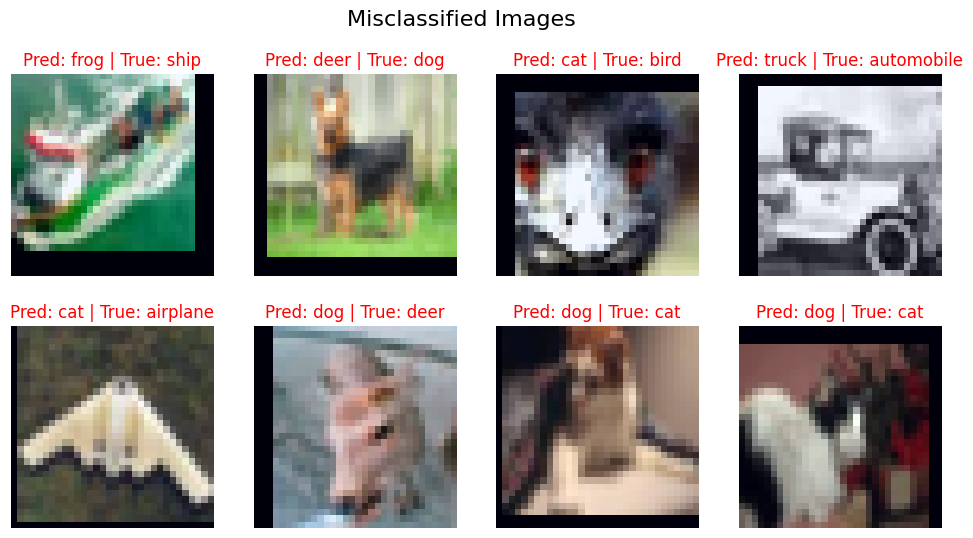

In [33]:
# Extract 8 misclassify images, to analyze error
class_names = ['airplane', 'automobile', 'bird', 'cat', 
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

model.load_state_dict(torch.load("best_model.pth"))
model.to(device)
model.eval()

wrong_images = []
wrong_labels = []
wrong_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        for i in range(len(labels)):
            if preds[i] != labels[i]: 
                wrong_images.append(images[i].cpu().numpy())
                wrong_labels.append(class_names[labels[i].cpu().item()])
                wrong_preds.append(class_names[preds[i].cpu().item()])
                
            if len(wrong_images) >= 8:
                break
        if len(wrong_images) >= 8:
            break

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
fig.suptitle("Misclassified Images", fontsize=16)

for i, ax in enumerate(axes.flat):
    img = wrong_images[i].transpose(1, 2, 0)
    img = (img - img.min()) / (img.max() - img.min())

    ax.imshow(img)
    ax.set_title(f"Pred: {wrong_preds[i]} | True: {wrong_labels[i]}", color="red")
    ax.axis("off")

plt.show()


AttributeError: 'RemovableHandle' object has no attribute 'requires_grad_'